In [6]:
import numpy as np
import pandas as pd
import pybamm
import matplotlib.pyplot as plt
from pandas import DataFrame
from utils.generate_new_volume import generate_new_volume, generate_new_volume_anisotropic
from utils.physical_properties import *
from utils.plotting import plot_volume
from skimage.transform import rescale, downscale_local_mean

# 4 phase volumes
# phases = ['Pore','Crack','Particle','CBD']

# Diffusivity function to modify for Pybamm
def lico2_diffusivity(sto, T, coeff):
    """
    LiCo2 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """
    #D_ref = 1 * 10 ** (-13)
    D_ref = (coeff / 0.4) * 10 ** (-13) # 0.4 is a random number picked from some GAN runs
    E_D_s = 18550
    arrhenius = pybamm.exp(E_D_s / pybamm.pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

# Volume generation
def gen_vol_anisotropic(reduction, subregion_id, subregion, output_sz=512, is_scale_for_reduction=True):
    model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
    model_path = 'model/{}/{}'.format(model_name, model_name)

    # Need to modify output size so the size of the generated volume is the same regardless of training image resolution
    # lz size table for reference:
    # lz =  4 -> output dim = 64
    # lz =  6 -> output dim = 128
    # lz =  8 -> output dim = 192
    # lz = 10 -> output dim = 256
    # lz = 12 -> output dim = 320
    # lz = 18 -> output dim = 512
    # lz = 24 -> output dim = 704
    # lz = 32 -> output dim = 960
    # lz = 40 -> output dim = 1216
    # lz = 50 -> output dim = 1536
    # lz = 60 -> output dim = 1856
    # lz = 70 -> output dim = 2176
    # lz = 80 -> output dim = 2496
    # lz = 100 -> output dim = 3136
    
    # BIGGEST MY LAPTOP CAN HANDLE IS 512 OUTPUT DIM FOR 20% REDUCTION
    # Makes ~8x1x1 aspect ratio volume, enforces even latent vector dims (they have to be even)
    # as well as minimum size of 4. If output_sz is too small, it won't be 8x1x1.
    if is_scale_for_reduction:
        lz_0 = (np.ceil((((output_sz * reduction / (12.5 * 4)) / 0.2)+64)/(32*2))*2).astype(int)
        lz_1 = (np.ceil((((output_sz * reduction / 12.5) / 0.2)+64)/(32*2))*2).astype(int)
        lz_2 = (np.ceil((((output_sz * reduction) / 0.2)+64)/(32*2))*2).astype(int)
    else:
        lz_0 = (np.ceil(((output_sz / (12.5 * 4)) + 64)/(32*2))*2).astype(int)
        lz_1 = (np.ceil(((output_sz / 12.5) + 64)/(32*2))*2).astype(int)
        lz_2 = (np.ceil((output_sz + 64)/(32*2))*2).astype(int)

    vol = generate_new_volume_anisotropic(model_path=model_path, lz_0=lz_0, lz_1=lz_1, lz_2=lz_2)
    # downscale higher resolution images to avoid taking a really long time, rounding to preseve segmented
    # vol_reduced = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)
    return vol

def split_into_n_volumes(vol, num_parts, is_plot=False):
    side_len = max(vol.shape)
    long_side = np.argmax(vol.shape)
    idx_splits = np.round((np.arange(num_parts) + 1) * side_len / num_parts).astype(int)

    if is_plot:
        fig, ax = plt.subplots(1, num_parts, figsize=(20, 6))

    for i, idx in enumerate(idx_splits):
        if i == 0:
            if long_side == 0:
                vol_ = vol[0:idx, :, :]
            elif long_side == 1:
                vol_ = vol[:, 0:idx, :]
            else:
                vol_ = vol[:, :, 0:idx]
            vol_splits = [vol_]
        else:
            if long_side == 0:
                vol_ = vol[idx_splits[i-1]:idx, :, :]
            elif long_side == 1:
                vol_ = vol[:, idx_splits[i-1]:idx, :]
            else:
                vol_ = vol[:, :, idx_splits[i-1]:idx]
            vol_splits += [vol_]
        if is_plot:
            ii = int(min(vol_.shape) / 2)
            ax[i].imshow(vol_[ii, :, :], cmap = 'gray')
    
    return vol_splits

def calc_properties(vol):
    # Set all cracks and pores equal for porosity
    vol[vol==1] = 0
    vf_particle = volume_fraction(vol, phase_class=2)
    vf_pore     = volume_fraction(vol, phase_class=0)
    # # pybamm can fail at extreme values
    # if vf_particle > 0.85:
    #     vf_particle = 0.85
    # if vf_pore < 0.09:
    #     vf_pore = 0.09

    # Diffusivity and tortuosity
    # Set all phases to 0 except particle for taufactor
    vol[vol==3] = 0
    vol[vol==2] = 1
    homogenized_properties = compute_tau_and_D_eff(vol, verbose=False)
    D_eff = homogenized_properties['D_eff'].item()

    # PyBaMM model
    model = pybamm.lithium_ion.DFN()
    # Default parameter set
    params = pybamm.ParameterValues("Marquis2019")
    # Modify parameters
    params['Positive electrode porosity'] = vf_pore
    params['Positive electrode active material volume fraction'] = vf_particle
    params['Positive electrode diffusivity [m2.s-1]'] = lambda sto, T: lico2_diffusivity(sto, T, D_eff)
    # Run simulations at several rates
    current = params['Current function [A]'] # nominal is 1 C
    rate = [0.5, 1, 2]
    for r in rate:
        params['Current function [A]'] = r * current
        sim = pybamm.Simulation(model,parameter_values=params)
        try:
            sim.solve([0, 7200/r],initial_soc=1)
            sol = sim.solution
            capacity = sol['Discharge capacity [A.h]'].entries
        except:
            capacity = np.NaN
            
        if r == 0.5:
            qdis_Cb2 = np.max(capacity)
        if r == 1:
            qdis_1C = np.max(capacity)
        if r == 2:
            qdis_2C = np.max(capacity)
    
    return {
        "vf_particle": [vf_particle],
        "vf_pore": [vf_pore],
        "D_eff": [D_eff],
        "qdis_Cb2": [qdis_Cb2],
        "qdis_1C": [qdis_1C],
        "qdis_2C": [qdis_2C],
    }

def rve_analysis(volume, max_parts=10):
    # Break the volume into 1:N parts, calculate coefficient of variance versus # of parts
    # Save into a data frame with mean, std, coef_var vs num_parts and fraction
    num_parts = np.arange(max_parts) + 1
    stats_keys = ['mean_', 'std_', 'coefvar_']
    for n in num_parts:
        if n == 1:
            props = calc_properties(volume.copy())
            rve_results = {
                'fraction': [1],
                'n_parts': [1],
            }
            for key in props.keys():
                for stat in stats_keys:
                    if stat == 'mean_':
                        rve_results[stat + key] = props[key]
                    else:
                        rve_results[stat + key] = [np.NaN]
        else:
            rve_results['fraction'].append(1/n)
            rve_results['n_parts'].append(n)
            vol_splits = split_into_n_volumes(volume.copy(), n)
            for i, subvolume in enumerate(vol_splits):
                if i == 0:
                    props = calc_properties(subvolume)
                else:
                    props_ = calc_properties(subvolume)
                    for key in props.keys():
                        props[key].append(props_[key][0])
            for key in props.keys():
                for stat in stats_keys:
                    if stat == 'mean_':
                        rve_results[stat + key].append(np.mean(props[key]))
                    if stat == 'std_':
                        rve_results[stat + key].append(np.std(props[key]))
                    if stat == 'coefvar_':
                        coefvar = np.std(props[key]) / np.mean(props[key])
                        rve_results[stat + key].append(coefvar)
    return pd.DataFrame(rve_results)

def gen_volumes_and_rve(reduction, subregion_id, subregion, output_sz=512, is_scale_for_reduction=True,
                        num_replicates=10, rve_max_parts=10):
    # Generate an 8x1x1 aspect ratio volume from the specified generator with the long side length set to output_sz
    # Break the volume into 1:rve_max_parts subvolumes, calculate properties on all volumes
    # Save into a data frame with mean, std, coef_var vs num_parts and fraction
    # repeat for num_replicates
    # compute time will roughly scale with [num_replicates * (rve_max_parts!)] so don't get crazy
    
    num_parts = np.arange(rve_max_parts) + 1
    for idx_replicate in range(num_replicates):
        volume = gen_vol_anisotropic(reduction, subregion_id, subregion, output_sz, is_scale_for_reduction)
        for n_part in num_parts:
            if n_part == 1:
                props_ = calc_properties(volume.copy())
                props_['idx_replicate'] = [idx_replicate]
                props_['idx_part'] = [0]
                props_['n_part'] = [n_part]
                props_['fraction_vol'] = [1/n_part]
                if idx_replicate == 0 and n_part == 1:
                    props = props_
                else:
                    for key in props.keys():
                        props[key].append(props_[key][0])
            else:
                vol_splits = split_into_n_volumes(volume.copy(), n_part)
                for idx_part, subvolume in enumerate(vol_splits):
                    props_ = calc_properties(subvolume)
                    props_['idx_replicate'] = [idx_replicate]
                    props_['idx_part'] = [idx_part]
                    props_['n_part'] = [n_part]
                    props_['fraction_vol'] = [1/n_part]
                    for key in props.keys():
                        props[key].append(props_[key][0])
                del vol_splits
    del volume
    return pd.DataFrame(props)

### image scaling
- Scale of original image is 32px per micron, or, 0.03125 micron/px
- Original aspect is 12.5
- A big particle can be about 1/4th the height of the image, so minimum depth would be ~1/4th the height

| Scale | Width | Height |
|-------|-------|--------|
|100%   | 14967 |  1195  |
|80%    | 11974 |  956   |
|60%    | 8980  |  717   |
|40%    | 5987  |  478   |
|20%    | 2993  |  239   |

My laptop can get up to a generated width of 6000. 9000 explodes the computer

In [21]:
# lists of all the saved generators parameters, definitely not best practice to just hardcode it...
reduction =    [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
                0.4,0.6,0.8,1.0]
subregion_id = [1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,5,6,6,7,
                1,1,1,1]
subregion =    [1,2,3,4,5,6,7,2,3,4,5,6,7,3,4,5,6,7,4,5,6,7,5,6,7,6,7,7,
                1,1,1,1]

# # test case without so may calculations
# reduction =    [0.2, 0.2, 0.2]
# subregion_id = [1, 1, 2]
# subregion =    [1, 2, 2]

# long side of generated volume at 0.2 reduction, 1.0 reduction will be 5x side length in each dimension
# this code assumes an anisotropic volume, 8x1x1
output_sz = 512

is_concat = False
for red, sub_id, sub in zip(reduction, subregion_id, subregion):
    properties = gen_volumes_and_rve(red, sub_id, sub, output_sz=output_sz,
                                        num_replicates=5, rve_max_parts=10)
    properties.loc[:, 'reduction']    = red
    properties.loc[:, 'subregion_id'] = sub_id
    properties.loc[:, 'subregion']    = sub
    if not is_concat:
        volume_properties = properties
        is_concat = True
    else:
        volume_properties = pd.concat((volume_properties, properties))

volume_properties.reset_index(drop=True)
volume_properties.to_csv('results/volume_properties_rve.csv')

At t = 511.779 and h = 1.0396e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.87 and h = 2.68645e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 461.507 and h = 9.58558e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 170.598 and h = 1.62616e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 542.508 and h = 2.29511e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.599 and h = 2.20652e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.144 and h = 7.11047e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 476.871 and h = 2.93188e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.962 and h = 1.70652e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 552.441 and h = 4.2383e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At 

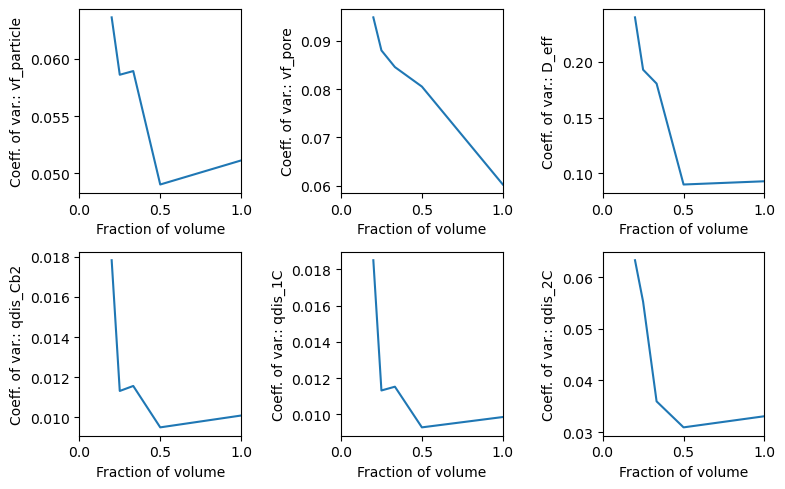

In [19]:
summary = volume_properties.groupby('n_part').describe()

vars = ['vf_particle', 'vf_pore', 'D_eff', 'qdis_Cb2', 'qdis_1C', 'qdis_2C']
fig, ax = plt.subplots(2, 3, figsize=(8, 5))
ax = ax.ravel()
for i, var in enumerate(vars):
    coeff_variation = summary[var]['std'] / summary[var]['mean']
    ax[i].plot(summary['fraction_vol']['max'], coeff_variation)
    ax[i].set_xlabel('Fraction of volume')
    ax[i].set_ylabel('Coeff. of var.: ' + var)
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, None])

plt.tight_layout()